To begin copy this notebook to your own drive:

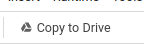


### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Run all cells** (in the menubar, select Runtime$\rightarrow$Run All).
3. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
4. **Upload the downloaded notebook (.ipynb file) to your repository**.

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

![shakespeare](https://i.imgur.com/81YZuel.jpg)

# Generating Shakespeare Using a Character-level Language Model

### From Words to Characters
In the previous two sections we dealt with word-level language models. But looking again at section 2, there is nothing that constraints us to using _words_ as the basic elemnents in our model. The model we analyzed in section 2 could just as well be character-based - just replace "word" with "character", and you are good to go. In this notebook we will train a small character-based language model that will help us generate Shakespearean-like (emphasis on the _like_...) texts.

### Question 3.a
Can you think of an advantage a character-based language model could have over a word-based language model? And what about the other way around: can you think of an advantage a word-based language model could have over a character-based language model? (Add your answer to the final submission pdf).

* Character-based language model advantage: 
  1. It can generate or recognize words that are not present in the training vocabulary by composing them from known characters. This makes them more robust when dealing with rare or specialized terms that may not be present in the training data of a word-based model.
  2. Better identifing and correcting misspaelled and typos. 

* Word-based language model advantage:
  1. Not 'making up' words.
  2. Better context and semantic Understanding: Word-based models capture the meaning of a text at a higher level of abstraction. MOre coherent and contextually appropriate responses.
  3. Computational Efficiency: Word-based models are computationally more efficient than character-based models, as they deal with larger units of text.


---



### Using PyTorch

We'll build our language model using PyTorch. PyTorch is a [very popular](https://thegradient.pub/state-of-ml-frameworks-2019-pytorch-dominates-research-tensorflow-dominates-industry/) open-source machine learning (and deep learning) framework developed by Facebook. In short:

> Pytorch is a Python-based scientific computing package targeted at two sets of audiences:
* A replacement for NumPy to use the power of GPUs
* A deep learning research platform that provides maximum flexibility and speed

To get familiar with PyTorch, check out this [quick tutorial](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html). In addition, another imporant difference from numpy is that PyTorch can automatically calculate the gradients needed for backpropagation, as explained [here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).

### Preparing the Data

Our dataset is a plain text file. For simplicity, we turn any potential unicode characters into plain ASCII by using the `unidecode` package.

In [1]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 16.6 MB/s eta 0:00:00


In [2]:
import string
import random
import re
import requests
import unidecode
url = "https://github.com/tau-nlp-course/NLP_HW2/raw/main/data/shakespeare.txt"


all_characters = string.printable
n_characters = len(all_characters)  # our vocabulary size (|V| from the handout)

dataset_as_string = unidecode.unidecode(requests.get(url).content.decode())
n_chars_in_dataset = len(dataset_as_string)
print(f'Total number of characters in our dataset: {n_chars_in_dataset}')

Total number of characters in our dataset: 1115394


In [3]:
all_characters

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [4]:
print(dataset_as_string[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


To make inputs out of this big string of text, we will split it into chunks.

In [5]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, n_chars_in_dataset - chunk_len)
    end_index = start_index + chunk_len + 1
    return dataset_as_string[start_index:end_index]

print(random_chunk())

 mock at death
With as big heart as thou. Do as thou list
Thy valiantness was mine, thou suck'dst it from me,
But owe thy pride thyself.

CORIOLANUS:
Pray, be content:
Mother, I am going to the market-place;
Chide me no more. I'll mountebank their loves,
Cog their hearts from them, and come home beloved
Of all the trades in Rome. Look, I am going:
Commend me to my wife. I'll return consul;
Or never


### Building Our Model

Our model consists of three main components:

1. [**Embedding**](https://pytorch.org/docs/stable/nn.html#embedding). A mapping between characters and their learned representations ("word vectors") \[correspoding to ${\boldsymbol L}$ in terms of the handout\]
2. [**GRU**](https://pytorch.org/docs/stable/nn.html#gru). \[correspoding to the computation of ${\boldsymbol h}^{(t)}$ in terms of the handout\]
3. **Output Layer**. A feed-forward neural network that transforms a hidden state at a timestep into a probability distribution of the next character. \[correspoding to the computation of $\hat{\boldsymbol y}^{(t)}$ in terms of the handout\] 

### Question 3.b
Complete the implementation of the `forward` method of our model.

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class OurModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(OurModel, self).__init__()
        self.input_size = input_size # 100
        self.hidden_size = hidden_size # 100
        self.output_size = output_size # 100
        self.num_layers = num_layers # 1
        
        self.embedding = nn.Embedding(input_size, hidden_size)  # In the terms of the handout, here d = D_h
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_, hidden):
        # General instructions:
        # Pass the embedded input through the GRU and use the output layer to get the next character distribution.
        # return that distribution and the next hidden state.
        # You may need to play around with the dimensions a bit until you get it right. Dimension-induced frustration is good for you!
        # -------------------------
        # YOUR CODE HERE
        embedded = self.embedding(input_).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        output = self.output_layer(output.view(1, -1))
        # -------------------------
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.num_layers, 1, self.hidden_size))

### Creating the Training Examples

Each chunk will be turned into a tensor by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [7]:
# Turn a string into list of longs
def chars_to_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(chars_to_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Now we can assemble a pair of input and target tensors (i.e. a single training example) for training, from a random chunk. The input will be all characters *except the last*, and the target will be all characters *except the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [8]:
def random_training_set():    
    chunk = random_chunk()
    inp = chars_to_tensor(chunk[:-1])
    target = chars_to_tensor(chunk[1:])
    return inp, target

### Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [9]:
import torch.nn.functional as F

def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = model.init_hidden()
    prime_input = chars_to_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist =  F.softmax(output / temperature, dim=-1)
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = chars_to_tensor(predicted_char)

    return predicted

### Training

The main training function

In [10]:
def train(inp, target):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = model(inp[c], hidden)
        loss += criterion(output, target[c].view(-1))

    loss.backward()
    optimizer.step()

    return loss.item() / chunk_len

A helper to print the amount of time passed:

In [11]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {math.floor(s)}s'

In [12]:
# DO NOT DELETE THIS CELL


Define the training parameters, instantiate the model, and start training:

In [13]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100  # (D_h from the handout)
num_layers = 1
lr = 0.005

model = OurModel(n_characters, hidden_size, n_characters, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())
    loss_avg += loss

    if epoch % print_every == 0:
        print(f'[time elapsed: {time_since(start)}  ;  epochs: {epoch} ({epoch / n_epochs * 100}%)  ;  loss: {loss:.4}]')
        print(evaluate('Wh', 200), '\n')  # generate text starting with 'Wh'

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[time elapsed: 0m 34s  ;  epochs: 100 (5.0%)  ;  loss: 2.127]
Whach.

LDARAAMTORTI IjIA:

Sow mither coolt
Whis mars mis mars muste ate coint't wilwt thime aspardkemand cone.

INIUTy thom of hay the a weat nood thome the det houst were of what thou sole thay shis  

[time elapsed: 1m 0s  ;  epochs: 200 (10.0%)  ;  loss: 2.04]
Whut beby ther to sall am much.

QUEELA:
But a sa se cencer and your rendet yeert deaat dias bemmy,
bothee.

CINIO:
This and his a lede land a lover makie, ix stone for be
Thou sare have me, for her but 

[time elapsed: 1m 26s  ;  epochs: 300 (15.0%)  ;  loss: 2.063]
Whightrou for thing hand cany so.

BUCIO:
Who hear heir thou him shad more you hike have no his thould guled.

GLUCESTI:
I what I poringoos what a her hain may,
And if an garcho her his a ablour of his  

[time elapsed: 1m 53s  ;  epochs: 400 (20.0%)  ;  loss: 1.944]
Whese treaceco
Sen histarderuchion he the seelf it ratce
for arstiast efortinge.

POME:
That for he fier all realy say to more? Cand to 

### Training Loss

Plotting the the losses that were computed during training can provide a further indication that the network was indeed learning (Add your plot to the final submission pdf).

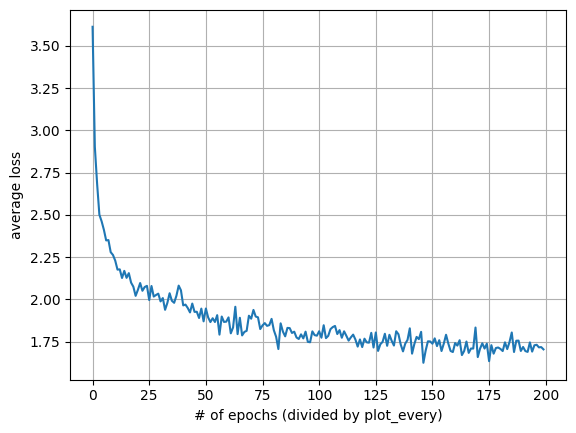

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.grid(True)
plt.xlabel('# of epochs (divided by plot_every)')
plt.ylabel('average loss')
plt.plot(all_losses)

In [15]:
import numpy as np
def evaluate_perplexity(text, model):
    perplexity = 0
    hidden = model.init_hidden()
    text = chars_to_tensor(text)
    for c in range(len(text) - 1):
        output, hidden = model(text[c], hidden)
        perplexity += criterion(output, text[c + 1].view(-1)).item()
    perplexity /= (len(text) - 1)
    return np.exp(perplexity)

In [16]:
shak = """
I shall lack voice: the deeds of Coriolanus
Should not be utter'd feebly. It is held
That valour is the chiefest virtue, and
Most dignifies the haver: if it be,
The man I speak of cannot in the world
Be singly counterpoised. At sixteen years,
When Tarquin made a head for Rome, he fought
Beyond the mark of others: our then dictator,
Whom with all praise I point at, saw him fight,
When with his Amazonian chin he drove
The bristled lips before him: be bestrid
An o'er-press'd Roman and i' the consul's view
Slew three opposers: Tarquin's self he met,
And struck him on his knee: in that day's feats,
When he might act the woman in the scene,
He proved best man i' the field, and for his meed
Was brow-bound with the oak. His pupil age
Man-enter'd thus, he waxed like a sea,
And in the brunt of seventeen battles since
He lurch'd all swords of the garland. For this last,
Before and in Corioli, let me say,
I cannot speak him home: he stopp'd the fliers;
And by his rare example made the coward
Turn terror into sport: as weeds before
A vessel under sail, so men obey'd
And fell below his stem: his sword, death's stamp,
Where it did mark, it took; from face to foot
He was a thing of blood, whose every motion
Was timed with dying cries: alone he enter'd
The mortal gate of the city, which he painted
With shunless destiny; aidless came off,
And with a sudden reinforcement struck
Corioli like a planet: now all's his:
When, by and by, the din of war gan pierce
His ready sense; then straight his doubled spirit
Re-quicken'd what in flesh was fatigate,
And to the battle came he; where he did
Run reeking o'er the lives of men, as if
'Twere a perpetual spoil: and till we call'd
Both field and city ours, he never stood
To ease his breast with panting.
"""

In [17]:
wiki ="""
New Zealand is one of the last major landmasses settled by humans. Radiocarbon dating, evidence of deforestation and mitochondrial DNA variability within Māori populations suggest that Eastern Polynesians first settled the New Zealand archipelago between 1250 and 1300, although newer archaeological and genetic research points to a date no earlier than about 1280, with at least the main settlement period between about 1320 and 1350, consistent with evidence based on genealogical traditions. This represented a culmination in a long series of voyages through the Pacific islands. Over the centuries that followed, the Polynesian settlers developed a distinct culture now known as Māori. The population formed different  (tribes) and  (subtribes) which would sometimes cooperate, sometimes compete and sometimes fight against each other. At some point, a group of Māori migrated to , now known as the Chatham Islands, where they developed their distinct Moriori culture. The Moriori population was all but wiped out between 1835 and 1862 in the Moriori genocide, largely because of Taranaki Māori invasion and enslavement in the 1830s, although European diseases also contributed. In 1862, only 101 survived, and the last known full-blooded Moriori died in 1933.

In a hostile 1642 encounter between Ngāti Tūmatakōkiri and Dutch explorer Abel Tasman's crew, four of Tasman's crew members were killed, and at least one Māori was hit by canister shot. Europeans did not revisit New Zealand until 1769, when British explorer James Cook mapped almost the entire coastline. Following Cook, New Zealand was visited by numerous European and North American whaling, sealing, and trading ships. They traded European food, metal tools, weapons, and other goods for timber, Māori food, artefacts, and water. The introduction of the potato and the musket transformed Māori agriculture and warfare. Potatoes provided a reliable food surplus, which enabled longer and more sustained military campaigns. The resulting intertribal Musket Wars encompassed over 600 battles between 1801 and 1840, killing 30,000–40,000 Māori. From the early 19th century, Christian missionaries began to settle New Zealand, eventually converting most of the Māori population. The Māori population declined to around 40% of its pre-contact level during the 19th century; introduced diseases were the major factor.

The British Government appointed James Busby as British Resident to New Zealand in 1832 following a petition from northern Māori. His duties were to protect British commerce, mediate between the unruly Pākehā (European) settlers and Māori, and to apprehend escaped convicts. In 1835, following an announcement of impending French settlement by Charles de Thierry, the nebulous United Tribes of New Zealand sent a Declaration of Independence to King William IV of the United Kingdom asking for protection. Ongoing unrest, the proposed settlement of New Zealand by the New Zealand Company (which had already sent its first ship of surveyors to buy land from Māori) and the dubious legal standing of the Declaration of Independence prompted the Colonial Office to send Captain William Hobson to claim sovereignty for the United Kingdom and negotiate a treaty with the Māori. The Treaty of Waitangi was first signed in the Bay of Islands on 6 February 1840. In response to the New Zealand Company's attempts to establish an independent settlement in Wellington and French settlers purchasing land in Akaroa, Hobson declared British sovereignty over all of New Zealand on 21 May 1840, even though copies of the treaty were still circulating throughout the country for Māori to sign. With the signing of the treaty and declaration of sovereignty, the number of immigrants, particularly from the United Kingdom, began to increase.

New Zealand was administered as part of the Colony of New South Wales until becoming a separate Crown colony, the Colony of New Zealand on 3 May 1841. Armed conflict began between the colonial government and Māori in 1843 with the Wairau Affray over land and disagreements over sovereignty. These conflicts, mainly in the North Island, saw thousands of imperial troops and the Royal Navy come to New Zealand and became known as the New Zealand Wars. Following these armed conflicts, large amounts of Māori land was confiscated by the government to meet settler demands.

The colony gained a representative government in 1852, and the first Parliament met in 1854. In 1856 the colony effectively became self-governing, gaining responsibility over all domestic matters (except native policy, which was granted in the mid-1860s). Following concerns that the South Island might form a separate colony, premier Alfred Domett moved a resolution to transfer the capital from Auckland to a locality near Cook Strait. Wellington was chosen for its central location, with Parliament officially sitting there for the first time in 1865.

In 1891 the Liberal Party came to power as the first organised political party. The Liberal Government, led by Richard Seddon for most of its period in office, passed many important social and economic measures. In 1893 New Zealand was the first nation in the world to grant all women the right to vote and in 1894 pioneered the adoption of compulsory arbitration between employers and unions.

In 1907, at the request of the New Zealand Parliament, King Edward VII proclaimed New Zealand a Dominion within the British Empire, reflecting its self-governing status. In 1947 the country adopted the Statute of Westminster, confirming that the British Parliament could no longer legislate for New Zealand without the consent of New Zealand.

Early in the 20th century, New Zealand was involved in world affairs, fighting in the First and Second World Wars and suffering through the Great Depression. The depression led to the election of the first Labour Government and the establishment of a comprehensive welfare state and a protectionist economy. New Zealand experienced increasing prosperity following the Second World War, and Māori began to leave their traditional rural life and move to the cities in search of work. A Māori protest movement developed, which criticised Eurocentrism and worked for greater recognition of Māori culture and of the Treaty of Waitangi. In 1975, a Waitangi Tribunal was set up to investigate alleged breaches of the Treaty, and it was enabled to investigate historic grievances in 1985. The government has negotiated settlements of these grievances with many iwi, although Māori claims to the foreshore and seabed proved controversial in the 2000s.
"""

In [22]:
dataset_as_string_shak = unidecode.unidecode(shak)
n_chars_in_dataset_shak = len(dataset_as_string_shak)
print(f'Total number of characters in our dataset: {n_chars_in_dataset_shak}')

Total number of characters in our dataset: 1755


In [23]:
dataset_as_string_wiki = unidecode.unidecode(wiki)
n_chars_in_dataset_wiki = len(dataset_as_string_wiki)
print(f'Total number of characters in our dataset: {n_chars_in_dataset_wiki}')

Total number of characters in our dataset: 6616


In [24]:
evaluate_perplexity(dataset_as_string_shak, model)

6.769117782221575

In [25]:
evaluate_perplexity(dataset_as_string_wiki, model)

16.2687740098086